In [1]:
#imports
import ffmpeg, numpy as np, matplotlib.pyplot as plt
import warnings
import scipy.signal
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
#read in file
def readAudioFromFile(filename):
    try:
        input_audio, err = (ffmpeg
                    .input(filename)
                    .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
                    .overwrite_output()
                    .run(capture_stdout=True, capture_stderr=True)
                    )
    except ffmpeg.Error as e:
        print(e.stderr)
    read_audio = np.fromstring(input_audio, dtype=np.int16).astype(np.float16)
    return read_audio

#read in file but add effect
def readAudioFromFileAddFilter(filename):
    try:
        input_audio, err = (ffmpeg
                    .input(filename)
                    .filter("equalizer", f=1000, t='q', w=100, g=10)
                    .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
                    .overwrite_output()
                    .run(capture_stdout=True, capture_stderr=True)
                    )
    except ffmpeg.Error as e:
        print(e.stderr)
    read_audio = np.fromstring(input_audio, dtype=np.int16).astype(np.float16)
    return read_audio

clean_sample_audio = readAudioFromFile("../recordings/sample_ffmpeg.wav")
effected_sample_audio = readAudioFromFileAddFilter("../recordings/sample_ffmpeg.wav")
print(clean_sample_audio[96000:144000])
print(np.shape(effected_sample_audio))

[-160. -145. -127. ...   99.   96.   96.]
(284802,)


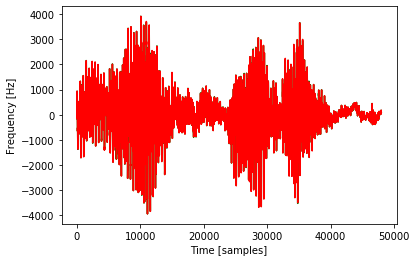

In [3]:
plt.plot(clean_sample_audio[96000:144000], color="green")
plt.plot(effected_sample_audio[96000:144000], color="red")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [samples]')
plt.show()

dry signal:


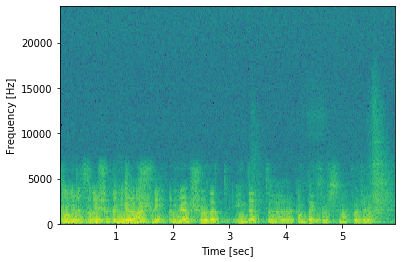

wet signal:


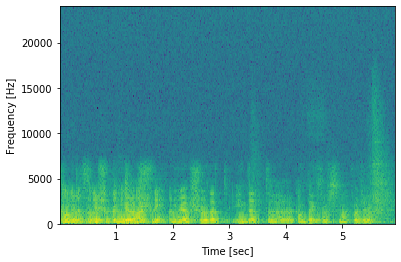

L2 distance: 3052.8052


In [4]:
def compute_distance(audio_1, audio_2):
    f_1, t_1, spec_1 = scipy.signal.spectrogram(audio_1, fs=48000)
    f_2, t_2, spec_2 = scipy.signal.spectrogram(audio_2, fs=48000)
    return np.linalg.norm(spec_1[:-1] - spec_2[:-1])

f_dry, t_dry, spec_dry = scipy.signal.spectrogram(clean_sample_audio, fs=48000)
f_wet, t_wet, spec_wet = scipy.signal.spectrogram(effected_sample_audio, fs=48000)

print("dry signal:")
plt.pcolormesh(t_dry, f_dry, np.log(spec_dry))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print("wet signal:")
plt.pcolormesh(t_wet, f_wet, np.log(spec_wet))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#plt.plot(spec_dry, color="green")
#plt.plot(spec_wet, color="red")
#plt.show()

distance = np.linalg.norm(spec_dry[:-1] - spec_wet[:-1])
print("L2 distance:", distance)

In [6]:
#stochastic hill-climbing function which changes EQ values
def apply_random_effect(source_audio):
    
    r_freq = np.random.randint(0, 24000)
    r_width = np.random.randint(0, 2000)
    r_gain = np.random.randint(-24, 24)
    
    x = np.round(source_audio).astype('int16')
    effected_audio = None
    try:
        #define graph
        process_audio = (ffmpeg
            .input('pipe:', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
            .filter("equalizer", f=r_freq, t='q', w=r_width, g=r_gain)
            .output('pipe:', format='s16le', acodec='pcm_s16le', ac=1, ar='48k')
            .run_async(pipe_stdin=True, pipe_stdout=True)
        )
        
        #pipe in the audio
        process_audio.stdin.write(
            source_audio
            .astype(np.int16)
            .tobytes()
        )
        process_audio.stdin.close()
        
        signal = process_audio.stdout.read()
        effected_audio = np.fromstring(signal, dtype=np.int16).astype(np.float16)
        process_audio.stdout.close()
        
    except ffmpeg.Error as e:
        print(e.stderr)
        sys.exit(1)
    return effected_audio

def stochastic_hill_climb(source_audio, target_audio, iterations):
    #compute the distance between both files
    best_distance = compute_distance(source_audio, target_audio)
    best_audio = source_audio
    
    for i in range(iterations):
        if (i % 100 == 0):
            print("iteration", i)
        #create a randomly effected candidate audio file (as float)
        new_audio = apply_random_effect(best_audio)
        #find the distance between both samples
        new_distance = compute_distance(new_audio, target_audio)
        if new_distance < best_distance:
            print("NEW best distance of", new_distance, "@ iteration", i)
            best_distance = new_distance
            best_audio = new_audio
    
    return best_audio

stochastic_hill_climb(clean_sample_audio[96000:144000], 
                      effected_sample_audio[96000:144000],
                      800)

iteration 0
NEW best distance of 243.75497 @ iteration 3
iteration 100
NEW best distance of 242.60379 @ iteration 130
iteration 200
NEW best distance of 241.80179 @ iteration 202
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700


array([-162., -150., -127., ...,  100.,   96.,   94.], dtype=float16)